<a href="https://colab.research.google.com/github/ruizleandro/Ensemble-Learning-and-Boosting/blob/main/Ensemble_Learning_in_Scikit_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow (Chapter 7).

# Quick Example

> Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35,
                                                    random_state=42)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [15]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8514285714285714
RandomForestClassifier 0.9142857142857143
SVC 0.9028571428571428
VotingClassifier 0.9057142857142857


As you can see, the voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called _soft voting_. It often achieves higher performance than ahrd voting because it gives more weight to highly confident votes. All you need to do is replace `voting='hard'` with `voting='soft'` and ensure that all classifiers can estimate class probabilities. This is not the case of the `SVC` class by default, so you need to set its `probability` hyperparameter to `True` (this will make the `SVC` class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method). Let's see how it looks our ensemble model with these modifications:

In [16]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8514285714285714
RandomForestClassifier 0.92
SVC 0.9028571428571428
VotingClassifier 0.9142857142857143


# Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed _with_ replacement, this method is called _bagging_ (short for _bootstrap aggregating_). When sampling is performed _without_ replacement, it is called _pasting_.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the _statistical mode_ (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

## Bagging and Pasting in Scikit-Learn

You can use `BaggingClassifier` for classification tasks, and `BaggingRegressor` for regression.

Some parameters for the `BaggingClassifier`:

* `n_estimators`: number of classifiers used in the ensemble.
* `max_samples`: number of samples from the training set to fit every classifier.
* `bootstrap`: `True` for using bagging, `False` for using pasting.
* `n_jobs`: number of CPU cores to use for training (`-1` means use all available cores).

Here's an example of bagging:

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=1000,
    max_samples=200, bootstrap=True, n_jobs=-1, random_state=0)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.9057142857142857


And here an example of pasting:

In [ ]:
pas_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=1000,
    max_samples=200, bootstrap=False, n_jobs=-1, random_state=0)
pas_clf.fit(X_train, y_train)
y_pred = pas_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.9085714285714286


Here is the example with only one tree doing all the job:

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8714285714285714


## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a `BaggingClassifier` samples _m_ training instances with replacement (`bootstrap=True`), where _m_ is the size of the trainin set. This means that only about 63 % of the training instances are sampled on average for each predictor. The remaining 37 % of the training instances that are not sampled are called _out-of-bag_ (oob) instances. Note that they are not the same 37 % for all predictors. 

Since a predictor never sees the oob instances during training, it can be evaluated on these instances without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor. 

In Scikit-Learn, you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic oob evaluation after training. The resulting evaluation score is available through the `oob_score_` variable:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9061538461538462

According to this oob evaluation, this `BaggingClassifier` is likely to achieve about 90.6 % accuracy on the test set. Let's verify it:

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9142857142857143

We get 91.4 % accuracy on the test set! Close enough!

Even we have available the oob decision function:

In [ ]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.97206704, 0.02793296],
       [1.        , 0.        ],
       ...,
       [0.99408284, 0.00591716],
       [0.88333333, 0.11666667],
       [0.        , 1.        ]])

## Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features as well. This is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called _Random Patches_ method. Keeping all training instances (i.e., `bootstrap=False` and `max_samples=1.0`) but sampling features (i.e., `bootstrap_features=True` and/or `max_features` smaller than 1.0) is called the _Random Subspaces_ method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

# Boosting

_Boosting_ (originally called _hypothesis boosting_) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are _AdaBoost_ (short for _Adaptive Boosting_) and _Gradient Boosting_.

## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that the predictors have different weights depending on their overall accuracy on the weighted training set.

Scikit-Learn actually uses a multiclass versoin of AdaBoost called SAMME (which stands for _Stagewise Additive Modeling using a Multiclass Exponential loss function_). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), Scikit-Learn can use a variant of SAMME called SAMME.R (the _R_ stands for "Real"), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200 _Decision Stumps_ using Scikit-Learn's `AdaBoostClassifier` class (as you mgiht expect, there is also an `AdaBoostRegressor` class). A Decision Stump is a Decision Tree with `max_depth=1`--i.e., a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the `AdaBoostClassifier` class:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9085714285714286

> If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators of more strongly regularizing the base estimator.

## Gradient Boosting

Another very popular Boosting algorithm is _Gradient Boosting_. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, eahc one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the _residual errors_ made by the previous predictor.

> Note: the following code and text are an extract from the notebook "_Supervised Learning_":

The gradient boosted regression tree is another ensemble method that combines multiple decision trees to create more powerful model. Despite the "regression" in the name, these models can be used for regression and classification. In contrast to the random forest approach, gradient boosting works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted trees; instead, strong pre-pruning is used. Gradient boosted trees often use very shallow trees, of depth one to five, which makes the model smaller in terms of memory and makes prediction faster.

The main idea behind gradient boosting is to combine many simple models (in this context known as weak learners), like shallow trees. Each tree can only provide good predictions on part of the data, and so more and more trees are added to iteratively improve performance.

Gradient boosted trees are frequently the winning entries in machine learning competitions, and are widely used in industry. They are generally a bit more sensitive to parameter settings than random forests, but can provide better accuracy if the parametersare set correctly.

Apart for the pre-pruning and the number of trees in the ensemble, another important parameter of gradient boosting is the learning_rate which controls how strongly each tree can make stronger corrections, allowing for more complex models. Adding more trees to the ensemble, which can be accomplished by increasing n_estimators, also increases the model complexity, as the model has more chances to correct mistakes on the training set.

Here is an example of using GradientBoostingClassifier on the Breast Cancer dataset. By default, 100 trees of maximum depth 3 and a learning rate of 0.1 are used:

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


As the training set accuracy is 100 %, we are likely to be overfitting. To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate:

In [12]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [13]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


Both methods of decreasing the model complexity reduced the training set accuracy, as expected. In this case, lowering the maximum depth of the trees provided a significant improvement of the model, while lowering the learning rate only increased the generalization performance slightly.

As for the other decision tree-based models, we can again visualize the feature importances to get more insight into our model. As we used 100 trees, it is impractical to inspect them all, even if they are all of depth 1:

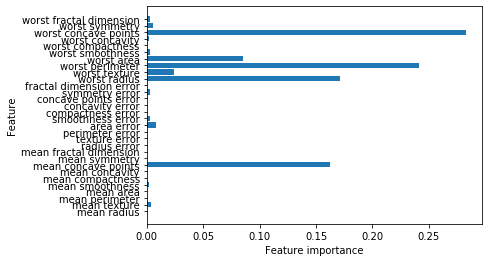

In [ ]:
def plot_feature_importances_cancer(model):
  n_features = cancer.data.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), cancer.feature_names)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

We can see that the feature importances of the gradient boosted trees are somewhat similar to hte feature importances of the random forests, though the gradient boosting completely ignored some of the features.

As both gradient boosting and random forests perform well on similar kinds of data, a common approach os to first try random forests, which work quite robustly. If random forests work well but prediction time is at a premium, or it is important to squeeze out the last percentage of accuracy from the machine learning model, moving to gradient boosting often helps. 

If you want to apply gradient boosting to a large-scale problem, it might be worth looking into the `xgboost` package and its Python interface, which at the time of writing is faster (and sometimes easier to tune) than the `scikit-learn` implementation of gradient boosting on many datasets.


**Strenghts, weaknesses, and parameters.** Gradient boosted decision trees are among the most powerful and widely used models for supervised learning. Their main drawback is that they require careful tuning of the parameters and may take a long time to train. Similarly to other tree-based models, the algorithm works well without scaling and on mixture of binary and continuous features. As with other tree-based models, it also often does not work well on high-dimensional sparse data.

The main parameters of gradient boosted tree models are the number of trees, `n_estimators`, and the `learning_rate`, which controls the degree to which each tree  is allowed to correct the mistakes of the previous trees. These two parameters are highly interconnected, as a lower `learning_rate` means that more trees are needed to build a model of similar complexity. In contrast to random forests, where a higher `n_estimators` value is always better, increasing `n_estimators` depending on the time and memory budget, and then search over different `learning_rate`s.

Another important parameter is `max_depth` (or alternatively `max_leaf_nodes`), to reduce the complexity of each tree. Usually `max_depth` is set very low for gradient boosted models, often not deeper than five splits.

# Stacking